# Model Interpretability Analysis

This notebook analyzes the DuaLK model's interpretability through:
1. Disease-level embedding evolution (HAKE initialization vs. trained GNN embeddings)
2. Attention score analysis for case study patients

## 1. Setup and Data Loading

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

from models.model import DuaLK

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11

In [14]:
data_path = 'data/mimic3'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

initial_embeddings = torch.load('./saved/train/initial_embeddings.pth', map_location='cpu')
checkpoint = torch.load('./saved/train/checkpoint.pth', map_location='cpu')

with open(f'{data_path}/encoded/code_maps.pkl', 'rb') as f:
    maps = pickle.load(f)
    code_map_pretrain = maps['code_map_pretrain']

with open(f'{data_path}/standard/codes_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)
    test_codes_x, test_codes_y, test_labs_x, _ = dataset['test_codes_data']

with open(f'{data_path}/graph/disease2disease.pkl', 'rb') as f:
    graph_data = pickle.load(f)
    edge_index = graph_data['edge_index']
    edge_weight = graph_data['edge_weight']

print(f'Initial embeddings shape: {initial_embeddings.shape}')
print(f'Test data shape: {test_codes_x.shape}')
print(f'Number of codes in code_map_pretrain: {len(code_map_pretrain)}')

Initial embeddings shape: torch.Size([6982, 2000])
Test data shape: (1000, 42, 39)
Number of codes in code_map_pretrain: 6981


## 2. ICD-9 Code Mapping

In [15]:
icd9_dict = {
    "Heart Failure": [
        "428.0", "428.1",
        "428.20", "428.21", "428.22", "428.23",
        "428.30", "428.31", "428.32", "428.33",
        "428.40", "428.41", "428.42", "428.43",
        "428.9"
    ],
    "Hypertension": [
        "401.0", "401.1", "401.9"
    ],
    "Acute Rheumatic Fever": [
        "390",
        "391.0", "391.1", "391.2", "391.8", "391.9",
        "392.0", "392.9"
    ]
}

disease_colors = {
    "Heart Failure": "#3498db",
    "Hypertension": "#e74c3c",
    "Acute Rheumatic Fever": "#2ecc71"
}

disease_indices = {}
for disease, codes in icd9_dict.items():
    indices = []
    for code in codes:
        if code in code_map_pretrain:
            indices.append(code_map_pretrain[code])
    disease_indices[disease] = indices
    print(f'{disease}: {len(indices)} codes found')

all_disease_indices = []
all_disease_labels = []
for disease, indices in disease_indices.items():
    all_disease_indices.extend(indices)
    all_disease_labels.extend([disease] * len(indices))

print(f'\nTotal disease codes to visualize: {len(all_disease_indices)}')

Heart Failure: 15 codes found
Hypertension: 3 codes found
Acute Rheumatic Fever: 4 codes found

Total disease codes to visualize: 22


## 3. Embedding Evolution Visualization

In [16]:
model_config = {
    'init_dim': 2000,
    'GNN': {
        'type': 'gat',
        'dims': (256, 256),
        'dropout': 0.,
    },
    'Attention': {
        'dropout': 0.2,
    },
    'Decoder': {
        'dims': (256, 128),
        'dropout': 0.4,
    },
    'Classifier': {
        'dims': [256],
        'dropout': 0.4,
    }
}

num_classes = [159, 115, 16, test_codes_y.shape[1]]

data = Data(x=initial_embeddings.float(), 
            edge_index=torch.tensor(edge_index), 
            edge_weight=torch.tensor(edge_weight).float())

model = DuaLK(model_config=model_config, emb_init=data.x, num_classes=num_classes,
              use_lab=True, code_fuse='simple', visit_fuse='simple', 
              train_type='finetune', gnn_type='gat')
model.load_state_dict(checkpoint)
model.eval()

print('Model loaded successfully')

Model loaded successfully


In [17]:
initial_emb_all = initial_embeddings.numpy()

with torch.no_grad():
    trained_emb_full = model.gnn_layer(data.edge_index, data.edge_weight)
trained_emb_all = trained_emb_full.cpu().numpy()

print(f'All embeddings shape: Initial={initial_emb_all.shape}, Trained={trained_emb_all.shape}')
print(f'Will visualize {len(all_disease_indices)} disease codes from the full embedding space')

All embeddings shape: Initial=(6982, 2000), Trained=(6982, 256)
Will visualize 22 disease codes from the full embedding space


In [18]:
tsne_init = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
coords_init_all = tsne_init.fit_transform(initial_emb_all)

tsne_trained = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
coords_trained_all = tsne_trained.fit_transform(trained_emb_all)

coords_init = coords_init_all[all_disease_indices]
coords_trained = coords_trained_all[all_disease_indices]

print(f't-SNE completed on {len(initial_emb_all)} diseases')
print(f'Extracted coordinates for {len(all_disease_indices)} target diseases')

t-SNE completed on 6982 diseases
Extracted coordinates for 22 target diseases


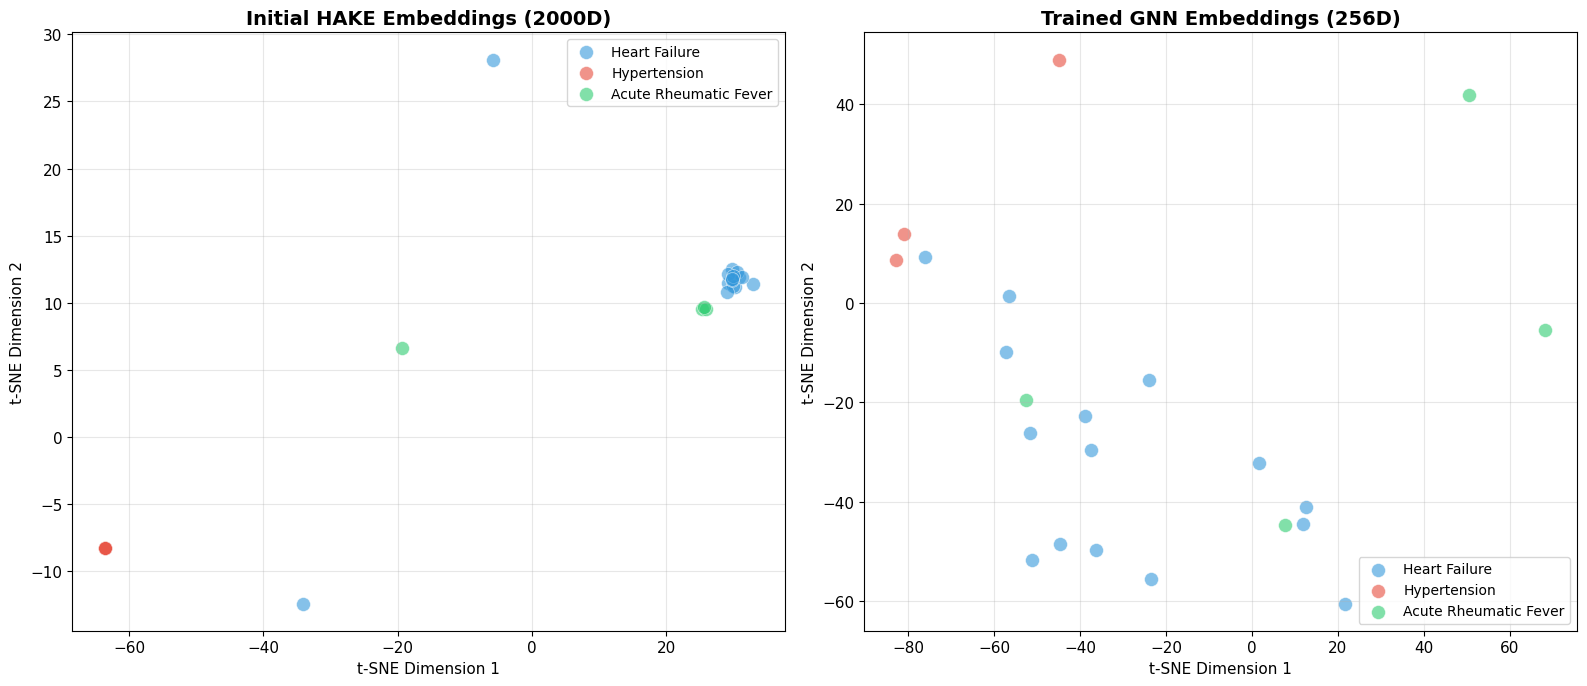

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for disease in disease_indices.keys():
    mask = [label == disease for label in all_disease_labels]
    axes[0].scatter(coords_init[mask, 0], coords_init[mask, 1], 
                   c=disease_colors[disease], label=disease,
                   s=100, alpha=0.6, edgecolors='white', linewidth=0.5)
    axes[1].scatter(coords_trained[mask, 0], coords_trained[mask, 1],
                   c=disease_colors[disease], label=disease,
                   s=100, alpha=0.6, edgecolors='white', linewidth=0.5)

axes[0].set_title('Initial HAKE Embeddings (2000D)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Dimension 1')
axes[0].set_ylabel('t-SNE Dimension 2')
axes[0].legend(loc='best', frameon=True, fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Trained GNN Embeddings (256D)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Dimension 1')
axes[1].set_ylabel('t-SNE Dimension 2')
axes[1].legend(loc='best', frameon=True, fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Patient Selection for Case Studies

In [20]:
visit_counts = (test_codes_x != 0).any(axis=-1).sum(axis=1)
valid_visit_mask = (visit_counts >= 2) & (visit_counts <= 4)
valid_patient_indices = np.where(valid_visit_mask)[0]

print(f'Patients with 3-5 visits (2-4 in X, 1 in y): {len(valid_patient_indices)}')

np.random.seed(42)
selected_patient_indices = np.random.choice(valid_patient_indices, size=5, replace=False)

print(f'Selected patient indices: {selected_patient_indices}')

Patients with 3-5 visits (2-4 in X, 1 in y): 253
Selected patient indices: [843  24 296 814 450]


## 4. ICD-9 Code to Disease Name Mapping

In [21]:
from preprocess.auxiliary import load_icd2name

icd2name, unmatched = load_icd2name('resources', code_map_pretrain)
print(f'Loaded {len(icd2name)} ICD-9 code descriptions')
print(f'Unmatched codes: {len(unmatched)}')

reverse_code_map = {v: k for k, v in code_map_pretrain.items()}

def get_disease_name(code_idx):
    icd_code = reverse_code_map.get(code_idx, None)
    if icd_code and icd_code in icd2name and icd2name[icd_code] is not None:
        return f"{icd2name[icd_code]} ({icd_code})"
    elif icd_code:
        return f"Code {icd_code}"
    return f"Unknown code {code_idx}"

There is 0 unmatched ICD9CM codes
Loaded 6981 ICD-9 code descriptions
Unmatched codes: 0


In [22]:
def extract_attention_scores(model, data, patient_codes_x):
    model.eval()
    codes_x = torch.tensor(patient_codes_x).unsqueeze(0).to(device)
    
    embeddings = model.gnn_layer(data.edge_index.to(device), data.edge_weight.to(device))
    
    visit_attention_scores = []
    visit_codes_list = []
    
    with torch.no_grad():
        for visit in range(codes_x.shape[1]):
            visit_codes = codes_x[0, visit, :]
            visit_codes = visit_codes[visit_codes > 0]
            if len(visit_codes) == 0:
                continue
            
            code_embeddings = embeddings[visit_codes]
            _, visit_attn = model.visit_attention(code_embeddings, return_attention=True)
            
            visit_attention_scores.append(visit_attn.cpu().numpy())
            visit_codes_list.append(visit_codes.cpu().numpy())
        
        visit_embeddings = []
        for visit in range(codes_x.shape[1]):
            visit_codes = codes_x[0, visit, :]
            visit_codes = visit_codes[visit_codes > 0]
            if len(visit_codes) == 0:
                continue
            code_embeddings = embeddings[visit_codes]
            visit_embedding = model.visit_attention(code_embeddings)
            visit_embeddings.append(visit_embedding)
        
        if len(visit_embeddings) > 0:
            visit_embeddings_tensor = torch.stack(visit_embeddings)
            _, patient_attn = model.patient_attention(visit_embeddings_tensor, return_attention=True)
            patient_attention_scores = patient_attn.cpu().numpy()
        else:
            patient_attention_scores = None
    
    return visit_attention_scores, visit_codes_list, patient_attention_scores

## 7. Case Study Analysis

In [23]:
data = data.to(device)
model = model.to(device)

for patient_idx in selected_patient_indices:
    patient_codes = test_codes_x[patient_idx]
    patient_labels = test_codes_y[patient_idx]
    
    visit_attn_scores, visit_codes, patient_attn_scores = extract_attention_scores(
        model, data, patient_codes
    )
    
    print(f"\n{'='*80}")
    print(f"Patient {patient_idx}")
    print(f"{'='*80}\n")
    
    for visit_idx, (codes, attn) in enumerate(zip(visit_codes, visit_attn_scores)):
        print(f"  Visit {visit_idx + 1}:")
        attn_mean = attn.mean(axis=-1)[:len(codes)]
        
        for code, att in zip(codes, attn_mean):
            disease_name = get_disease_name(int(code))
            print(f"    - {disease_name}: attention = {att:.4f}")
        
        if patient_attn_scores is not None:
            patient_att = patient_attn_scores.mean(axis=-1)[visit_idx]
            print(f"    Visit {visit_idx + 1} overall attention: {patient_att:.4f}\n")
    
    predicted_indices = np.where(patient_labels > 0)[0]
    print(f"  Predicted diseases in next visit:")
    for idx in predicted_indices[:10]:
        disease_name = get_disease_name(int(idx))
        print(f"    - {disease_name}")
    print(f"\n{'='*80}\n")


Patient 843

  Visit 1:
    - Edema of larynx (478.6): attention = 0.1202
    - Other convulsions (780.39): attention = 0.0560
    - Abscess of lung (513.0): attention = 0.1367
    - Other pulmonary embolism and infarction (415.19): attention = 0.0430
    - Acute respiratory failure (518.81): attention = 0.0845
    - Systemic lupus erythematosus (710.0): attention = 0.2026
    - Nephritis and nephropathy, not specified as acute or chronic, in diseases classified elsewhere (583.81): attention = 0.1983
    - Raynaud's syndrome (443.0): attention = 0.1260
    - Hypopotassemia (276.8): attention = 0.0326
    Visit 1 overall attention: 0.5144

  Visit 2:
    - End stage renal disease (585.6): attention = 0.1688
    - Pneumonia, organism unspecified (486): attention = 0.1110
    - Primary hypercoagulable state (289.81): attention = 0.0397
    - Systemic lupus erythematosus (710.0): attention = 0.1925
    - Awaiting organ transplant status (V49.83): attention = 0.0771
    - Chronic glomerulo